## Baseline Modeling
- 최소한의 성능을 보이는 기본 ML pipeline
- Modeling 성능 및 설계는 추후에 생각하고, 먼저 input과 output의 형태 및 process를 점검

## Package

In [20]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [21]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'

In [22]:
ym_list = ['201902', '201903', '201904', '201905', '201906', '201907']

def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

input_table = 'dumbo.user_input_matrix_for_reco_equip_monthly'
label_table = 'dumbo.user_label_matrix_for_reco_equip_monthly'
meta_table = 'dumbo.aips_equip_meta'

## Load data

In [4]:
conn = hive_connection('dmig')
df_input = load_from_hive(conn, 'select * from {}'.format(input_table))

2019-09-04 10:55:26,003 - YE_HIVE - INFO - ...tmp_db name = tmp_20190904_10_55_26_014ba537e7099d40a62c24331a6c41846458937c
2019-09-04 10:55:26,005 - YE_HIVE - INFO - Start creating table
2019-09-04 10:55:26,006 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190904_10_55_26_014ba537e7099d40a62c24331a6c41846458937c
2019-09-04 10:55:26,057 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190904_10_55_26_014ba537e7099d40a62c24331a6c41846458937c' is done
2019-09-04 10:58:24,569 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190904_10_55_26_014ba537e7099d40a62c24331a6c41846458937c 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from dumbo.user_input_matrix_for_reco_equip_monthly' is done
2019-09-04 10:58:24,816 - YE_HIVE - INFO - Elapsed Time = 178.81
2019-09-04 10:58:24,817 - Y

In [5]:
df_input.shape

(1555816, 434)

In [6]:
df_input.head()

svc_mgmt_num sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0   1004380709      1  44.0     44603.1667             3.0   
1   1005527212      2  34.0     58102.5000             0.0   
2   1040313817      1  40.0     40249.0000             0.0   
3   1048103507      2  39.0     31550.0000             0.0   
4   1052225601      2  24.0     27097.2500             0.0   

   last_eqp_buy_duration  tw_visit_days_fee_t_small  \
0                   74.0                        0.0   
1                  267.0                        0.0   
2                  123.0                        0.0   
3                   -6.0                        0.0   
4                  101.0                        0.0   

   location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
0                         53.0                                 0.0   
1                         13.0                                 0.0   
2                         15.0                                 0.0   
3                         13.0                                 0.0   
4                         10.0                                 0.0   

   mbr_discount_amt_family_restaurant  ...   mktg_dt  smart_phon_yn  \
0                                 0.0  ...  20170418              Y   
1                             13575.0  ...  20160311              Y   
2                                 0.0  ...  20150923              Y   
3                                 0.0  ...  20170921              Y   
4                                 0.0  ...  20180105              Y   

   tablet_yn_1  note_yn disp_size_larg_yn     eqp_siz_ctt flagship_yn  \
0            N        N                 N  148.9*68.1*8.0           Y   
1            N        N                 Y  150.9x72.6x7.7           Y   
2            N        Y                 Y             TBD           Y   
3            N        Y                 Y  162.5*74.8*8.6           Y   
4            N        N                 Y  149.2*70.6*8.4           N   

  eqp_mdl_size  eqp_mdl_ntwk  first_eqp_out_prc  
0         64GB            4G           935000.0  
1         32GB            4G           924000.0  
2         32GB            4G           899800.0  
3        256GB            4G          1254000.0  
4         32GB            4G           599500.0  

[5 rows x 434 columns]

In [23]:
conn = hive_connection('dmig')
df_label = load_from_hive(conn, 'select * from {}'.format(label_table))

2019-09-11 15:31:08,908 - YE_HIVE - INFO - ...tmp_db name = tmp_20190911_15_31_08_448835d94d339e305542ba362347e521adac0d1b
2019-09-11 15:31:08,910 - YE_HIVE - INFO - Start creating table
2019-09-11 15:31:08,912 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190911_15_31_08_448835d94d339e305542ba362347e521adac0d1b
2019-09-11 15:31:08,959 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190911_15_31_08_448835d94d339e305542ba362347e521adac0d1b' is done
2019-09-11 15:33:57,784 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190911_15_31_08_448835d94d339e305542ba362347e521adac0d1b 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from dumbo.user_label_matrix_for_reco_equip_monthly' is done
2019-09-11 15:33:58,022 - YE_HIVE - INFO - Elapsed Time = 169.11
2019-09-11 15:33:58,024 - Y

In [24]:
df_label.shape

(2185529, 19)

In [25]:
df_label.head()

svc_mgmt_num    chg_dt eqp_mdl_cd sale_chnl_cl_cd rep_eqp_mdl_cd  \
0   7271085649  20190301       A0VW            1101           A0M0   
1   7280459804  20190306       A0VW            1702           A0M0   
2   7039457478  20190304       A0ZA            1001           A0Z6   
3   7046019257  20190302       A0GI            1101           A0GF   
4   7015943233  20190314       A0IG            1101           A0B1   

      eqp_nm_rmk eqp_pet_nm mfact_nm   mktg_dt tablet_yn note_yn  \
0  갤럭시 노트 9_128G     갤럭시노트9  삼성전자(주)  20181130         N       Y   
1  갤럭시 노트 9_128G     갤럭시노트9  삼성전자(주)  20181130         N       Y   
2        갤럭시 S10     갤럭시S10  삼성전자(주)  20190225         N       N   
3             G7         G7  LG전자(주)  20180518         N       N   
4     갤럭시 S9_64G      갤럭시S9  삼성전자(주)  20180525         N       N   

  disp_size_larg_yn     eqp_siz_ctt flagship_yn eqp_mdl_size eqp_mdl_ntwk  \
0                 Y  161.9*76.4*8.8           Y        128GB           4G   
1                 Y  161.9*76.4*8.8           Y        128GB           4G   
2                 N  149.9*70.4*7.8           Y        128GB           4G   
3                 Y      153.2*71.9           Y         64GB           4G   
4                 N  147.7*68.7*8.5           Y         64GB           4G   

   first_eqp_out_prc    out_prc      ym  
0          1094500.0  1094500.0  201903  
1          1094500.0  1094500.0  201903  
2          1056000.0  1056000.0  201903  
3           898700.0   898700.0  201903  
4           957000.0   858000.0  201903

In [26]:
conn = hive_connection('dmig')
df_meta = load_from_hive(conn, 'select * from dumbo.aips_equip_meta_new')

2019-09-11 15:34:20,382 - YE_HIVE - INFO - ...tmp_db name = tmp_20190911_15_34_20_a8d8ad8b5c563265a983a057ef1ded0d9f1a189d
2019-09-11 15:34:20,384 - YE_HIVE - INFO - Start creating table
2019-09-11 15:34:20,385 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190911_15_34_20_a8d8ad8b5c563265a983a057ef1ded0d9f1a189d
2019-09-11 15:34:20,432 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190911_15_34_20_a8d8ad8b5c563265a983a057ef1ded0d9f1a189d' is done
2019-09-11 15:36:59,298 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190911_15_34_20_a8d8ad8b5c563265a983a057ef1ded0d9f1a189d 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from dumbo.aips_equip_meta_new' is done
2019-09-11 15:36:59,545 - YE_HIVE - INFO - Elapsed Time = 159.16
2019-09-11 15:36:59,547 - YE_HIVE - INFO - Start

In [27]:
df_meta.shape

(1621, 15)

In [28]:
df_meta[df_meta['eqp_mdl_cd']=='A01P']

eqp_mdl_cd rep_eqp_mdl_cd           eqp_nm_rmk     eqp_pet_nm mfact_nm  \
15       A01P           A01O  IPAD PRO 10.5_512GW  IPAD PRO 10.5    Apple   

     mktg_dt smart_phon_yn tablet_yn note_yn disp_size_larg_yn  \
15  20170713             N         Y       Y                 N   

        eqp_siz_ctt flagship_yn eqp_mdl_size eqp_mdl_ntwk  first_eqp_out_prc  
15  250.6*174.1*6.1           N        512GB           4G          1267200.0

In [30]:
df_meta[df_meta['first_eqp_out_prc']<10000].head(50)

Empty DataFrame
Columns: [eqp_mdl_cd, rep_eqp_mdl_cd, eqp_nm_rmk, eqp_pet_nm, mfact_nm, mktg_dt, smart_phon_yn, tablet_yn, note_yn, disp_size_larg_yn, eqp_siz_ctt, flagship_yn, eqp_mdl_size, eqp_mdl_ntwk, first_eqp_out_prc]
Index: []

In [29]:
df_label[df_label['first_eqp_out_prc']<10000].head(50)

Empty DataFrame
Columns: [svc_mgmt_num, chg_dt, eqp_mdl_cd, sale_chnl_cl_cd, rep_eqp_mdl_cd, eqp_nm_rmk, eqp_pet_nm, mfact_nm, mktg_dt, tablet_yn, note_yn, disp_size_larg_yn, eqp_siz_ctt, flagship_yn, eqp_mdl_size, eqp_mdl_ntwk, first_eqp_out_prc, out_prc, ym]
Index: []

In [31]:
# df_input.to_pickle(os.path.join(DATA_PATH, 'eqp_input.pkl'))
df_label.to_pickle(os.path.join(DATA_PATH, 'eqp_label.pkl'))
df_meta.to_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

In [38]:
df_input = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_input.pkl'))
df_label = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_label.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

In [39]:
df_input.shape, df_label.shape, df_meta.shape

((1555816, 434), (2187060, 20), (1849, 15))

## Check input data
- null, duplicate, type 등을 체크하고 drop이 필요한 것들은 drop 시킴

In [15]:
df_input.select_dtypes(include=['object']).columns

Index(['svc_mgmt_num', 'sex_cd', 'eqp_mdl_cd',
       'additional_svc_oksusu_scrb_type', 'fee_prod_id',
       'data_gift_recv_yn_bf_m2', 'filter_sex', 'copn_data_u1_yn_bf_m0',
       'svc_scrb_dt', 'channel',
       ...
       'mfact_nm', 'mktg_dt', 'smart_phon_yn', 'tablet_yn_1', 'note_yn',
       'disp_size_larg_yn', 'eqp_siz_ctt', 'flagship_yn', 'eqp_mdl_size',
       'eqp_mdl_ntwk'],
      dtype='object', length=101)

#### 필요없어 보이는 column 제외

In [16]:
[c for c in df_input if '_1' in c]

['tw_visit_days_fee_senior_12g',
 'mbr_discount_amt_11st',
 'tw_spd_chk_1m',
 'tw_tplan_chk_1m',
 'mbr_discount_cnt_11st',
 'eqp_mdl_cd_1',
 'eqp_out_prc_1',
 'op_sale_chnl_cl_cd_1',
 'tablet_yn_1']

In [17]:
# 다른 col로 대체가능한 것들
del_cols = ['nm_cust_num', 'eqp_mdl_cd', 'fee_prod_id', 
                'eqp_mdl_cd_1', 'eqp_out_prc_1', 'op_sale_chnl_cl_cd_1', 'tablet_yn_1']

# null 값이 많은 것들
del_cols2 = ['tw_visit_days_alacarte', 'tw_visit_days_shopguide', 'tw_visit_days_subsidy', 'tw_visit_days_device', 'tw_visit_days_accessory',
                'tw_visit_days_myshop', 'tw_visit_days_exhibition', 'tw_visit_days_internet', 'tw_visit_days_security', 'voc_rcv_cnt', 'voc_rvc_cnt']

In [18]:
del_cols_total = del_cols + del_cols2

df_input.drop(del_cols_total, axis=1, inplace=True)

df_input.shape

#### null 처리 -> 일단 주요 column 값이 null이면 해당 row 다 삭제

In [22]:
df_input.shape

(1555816, 417)

In [23]:
# null check
col_null_sum = df_input.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  svc_mgmt_num          1601
sex_cd                1601
age                   1601
real_avg_arpu         1601
roaming_cnt_m3        1601
                     ...  
sms_snd_cnt_baby      1601
ym                    1601
eqp_mdl_size         42322
eqp_mdl_ntwk         21661
first_eqp_out_prc    23884
Length: 405, dtype: int64


In [24]:
## 회선 번호가 없는 row 삭제
df_input = df_input[df_input.svc_mgmt_num.notnull()]
df_input.shape

(1554215, 417)

In [25]:
col_null_sum = df_input.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  eqp_mdl_size         42267
eqp_mdl_ntwk         21633
first_eqp_out_prc    23852
dtype: int64


### TODO

In [26]:
## TODO: 나중에는 전처리 해야함. 지금은 일단 row 삭제
df_input = df_input[df_input.eqp_mdl_size.notnull()]
df_input.shape

(1511948, 417)

In [29]:
col_null_sum = df_input.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  first_eqp_out_prc    273
dtype: int64


In [30]:
## TODO: 나중에는 전처리 해야함. 지금은 일단 row 삭제
df_input = df_input[df_input.first_eqp_out_prc.notnull()]
df_input.shape

(1511675, 417)

In [21]:
# zero check
zero_drop_list = []
for col in df_input.select_dtypes(include=['int', 'float']).columns:
    zero_rate = df_input[df_input[col]==0].shape[0] /df_input.shape[0]
    if zero_rate > 0.95:
        print('-'*20)
        print('col: ', col)
        print('zero_rate: ',zero_rate)
        print('')
        
        if zero_rate > 0.99:
            zero_drop_list.append(col)

In [ ]:
df_input.drop(zero_drop_list, axis=1, inplace=True)

In [32]:
# only one value check
for col in df_input.select_dtypes(include=['int', 'float']).columns:
    if df_input[col].nunique() == 1:
        print('-'*20)
        print('col: ', col)
        print('value: ', df_input[col].unique())
        print('')

## Check label data

In [33]:
df_label.shape

(2187060, 20)

In [34]:
# null check
col_null_sum = df_label.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  rep_eqp_mdl_cd        6103
eqp_nm_rmk            6103
eqp_pet_nm            6103
mfact_nm              6103
mktg_dt               6103
smart_phon_yn         6103
tablet_yn             6103
note_yn               6103
disp_size_larg_yn     6103
eqp_siz_ctt           6103
flagship_yn           6103
eqp_mdl_size         98829
eqp_mdl_ntwk          7462
first_eqp_out_prc     6677
out_prc               3366
dtype: int64


In [36]:
df_label.head()

svc_mgmt_num    chg_dt eqp_mdl_cd sale_chnl_cl_cd rep_eqp_mdl_cd  \
0   7029328479  20190511       A0ZK            1101           A0ZK   
1   7031892944  20190531       A0YC            1002           A0YC   
2   7270420789  20190506       A12X            1002           A124   
3   7248801028  20190824       A135            1002           A0XK   
4   7248801028  20190810       A14U            1002           A152   

       eqp_nm_rmk eqp_pet_nm mfact_nm   mktg_dt smart_phon_yn tablet_yn  \
0   갤럭시 S10+_128G    갤럭시S10+  삼성전자(주)  20190225             Y         N   
1             V50        V50  LG전자(주)  20190510             Y         N   
2         갤럭시 A30        A30  삼성전자(주)  20190503             Y         N   
3  갤럭시S10 5G_256G  갤럭시S10 5G  삼성전자(주)  20190405             Y         N   
4  갤럭시S10 5G_512G  갤럭시S10 5G  삼성전자(주)  20190405             Y         N   

  note_yn disp_size_larg_yn     eqp_siz_ctt flagship_yn eqp_mdl_size  \
0       N                 Y  157.6*74.1*7.8           Y        128GB   
1       N                 Y  158.7*75.8*7.7           Y        128GB   
2       N                 N  158.5*74.7*7.7           N         32GB   
3       N                 Y  162.6*77.1*7.9           Y        256GB   
4       N                 Y  162.6*77.1*7.9           Y        512GB   

  eqp_mdl_ntwk  first_eqp_out_prc    out_prc      ym  
0           4G          1155000.0  1155000.0  201905  
1           5G          1199000.0  1199000.0  201905  
2           4G           349800.0   349800.0  201905  
3           5G          1397000.0  1397000.0  201908  
4           5G          1556500.0  1430000.0  201908

In [39]:
df_label = df_label[df_label.rep_eqp_mdl_cd.notnull()]

In [40]:
# null check
col_null_sum = df_label.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  eqp_mdl_size         92726
eqp_mdl_ntwk          1359
first_eqp_out_prc      574
out_prc               2725
dtype: int64


### eqp_mdl_size(용량) 날리기로 결정

In [41]:
df_label.drop('eqp_mdl_size', axis=1, inplace=True)

In [42]:
df_label = df_label[df_label.out_prc.notnull()]

In [43]:
# null check
col_null_sum = df_label.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  eqp_mdl_ntwk    1086
dtype: int64


In [45]:
df_label = df_label[df_label.eqp_mdl_ntwk.notnull()]

In [46]:
# null check
col_null_sum = df_label.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  Series([], dtype: int64)


#### yn cols

In [47]:
yn_cols = [ c for c in df_input.columns if 'yn' in c]

In [48]:
print(yn_cols)

['data_gift_recv_yn_bf_m2', 'copn_data_u1_yn_bf_m0', 'rmk_omd_yn', 'smartwatch_yn', 'nh00000059_yn', 'data_gift_send_yn_bf_m0', 'copn_data_u1_yn_bf_m1', 'childwatch_yn', 'family_marriage_yn', 'tablet_yn', 'na00002040_yn', 'family_yn', 'nh00000037_yn', 'sec_dev_yn', 'nh00000084_yn', 'family_rep_yn', 'family_child_yn', 't_agr_t_eqpal_scrb_yn', 'nh00000133_yn', 'data_gift_recv_yn_bf_m0', 'nh00000114_yn', 'data_gift_send_yn_bf_m1', 'nh00000103_yn', 'nh00000039_yn', 'na00004430_yn', 'family_wire_comb_yn', 'family_small_yn', 'data_gift_send_yn_bf_m2', 'data_gift_recv_yn_bf_m1', 'copn_data_u1_yn_bf_m2', 'old_eqp_yn', 'smart_phon_yn', 'note_yn', 'disp_size_larg_yn', 'flagship_yn']


In [49]:
for c in yn_cols:
    print('col: ', c)
    print(df_input[c].nunique())
#     print(df_input[c].value_counts(dropna=False))

col:  data_gift_recv_yn_bf_m2
2
col:  copn_data_u1_yn_bf_m0
2
col:  rmk_omd_yn
3
col:  smartwatch_yn
2
col:  nh00000059_yn
2
col:  data_gift_send_yn_bf_m0
2
col:  copn_data_u1_yn_bf_m1
2
col:  childwatch_yn
2
col:  family_marriage_yn
2
col:  tablet_yn
2
col:  na00002040_yn
2
col:  family_yn
2
col:  nh00000037_yn
2
col:  sec_dev_yn
2
col:  nh00000084_yn
2
col:  family_rep_yn
2
col:  family_child_yn
2
col:  t_agr_t_eqpal_scrb_yn
3
col:  nh00000133_yn
2
col:  data_gift_recv_yn_bf_m0
2
col:  nh00000114_yn
2
col:  data_gift_send_yn_bf_m1
2
col:  nh00000103_yn
2
col:  nh00000039_yn
2
col:  na00004430_yn
2
col:  family_wire_comb_yn
2
col:  family_small_yn
2
col:  data_gift_send_yn_bf_m2
2
col:  data_gift_recv_yn_bf_m1
2
col:  copn_data_u1_yn_bf_m2
2
col:  old_eqp_yn
2
col:  smart_phon_yn
2
col:  note_yn
2
col:  disp_size_larg_yn
2
col:  flagship_yn
2


#### yn_col 중 nunique가 2가 아닌 column 제거

In [50]:
del_cols = ['rmk_omd_yn', 'sec_dev_yn', 't_agr_t_eqpal_scrb_yn']
df_input.drop(del_cols, axis=1, inplace=True)

In [51]:
yn_cols = [ c for c in df_input.columns if 'yn' in c]

#### filter cols

In [75]:
filter_cols = [c for c in df_input.columns if 'filter_' in c]

In [41]:
for c in filter_cols:
    print('col: ', c)
    print(df_input[c].nunique())
#     print(df_input[c].value_counts(dropna=False))

col:  filter_sex
2
col:  filter_svc_cd
1
col:  filter_block_obj_cl_cd
2
col:  filter_fee_prod
2
col:  filter_pps
1
col:  filter_smile
2
col:  filter_svc_st_cd
2
col:  filter_sktemployee
3
col:  filter_term_dt
1
col:  filter_svc_use_typ_cd
2
col:  filter_lte
3
col:  filter_agree_201
3
col:  filter_tfamilymoa
2
col:  filter_usim_indpnd_svc
2
col:  filter_eqp_mdl_cd
2
col:  filter_op_info_rejt_obj
2
col:  filter_alpa_cust
2
col:  filter_indv_corp_cl_cd
2
col:  filter_asgn_call_rgst_cust
2
col:  filter_col
2
col:  filter_agree_203
3
col:  filter_five_g
3
col:  filter_frgnr
2
col:  filter_trnd_info_rejt_obj
2


In [77]:
filter_cols

['filter_sex',
 'filter_svc_cd',
 'filter_block_obj_cl_cd',
 'filter_fee_prod',
 'filter_pps',
 'filter_smile',
 'filter_svc_st_cd',
 'filter_sktemployee',
 'filter_svc_use_typ_cd',
 'filter_lte',
 'filter_agree_201',
 'filter_tfamilymoa',
 'filter_usim_indpnd_svc',
 'filter_eqp_mdl_cd',
 'filter_op_info_rejt_obj',
 'filter_alpa_cust',
 'filter_indv_corp_cl_cd',
 'filter_asgn_call_rgst_cust',
 'filter_col',
 'filter_agree_203',
 'filter_five_g',
 'filter_frgnr',
 'filter_trnd_info_rejt_obj']

In [79]:
del_cols = ['filter_svc_cd', 'filter_sktemployee', 'filter_term_dt', 'filter_agree_201', 'filter_agree_203', 'filter_five_g']
df_input.drop(del_cols, axis=1, inplace=True)

In [80]:
filter_cols = [c for c in df_input.columns if 'filter_' in c]

#### dt cols

In [52]:
dt_cols = [c for c in df_input.columns if '_dt' in c]

In [53]:
dt_cols

['svc_scrb_dt',
 'fee_chg_dt',
 'cncl_aply_bf_equip_chg_dt',
 'cncl_aply_last_equip_chg_dt',
 'filter_term_dt',
 'scrb_sta_dt',
 'cust_birth_dt',
 'eqp_acqr_dt',
 'mktg_dt']

In [55]:
for col in dt_cols:
    print('col: ', col)
    print(df_input[df_input[col] == 'N/A'].shape[0])

col:  svc_scrb_dt
0
col:  fee_chg_dt
442
col:  cncl_aply_bf_equip_chg_dt
0
col:  cncl_aply_last_equip_chg_dt
0
col:  filter_term_dt
0
col:  scrb_sta_dt
23013
col:  cust_birth_dt
0
col:  eqp_acqr_dt
0
col:  mktg_dt
0


#### fee_chg_dt 값이 'N/A'인 row drop

In [56]:
df_input = df_input[df_input['fee_chg_dt'] != 'N/A'] 

#### scrb_sta_dt, cust_birth_dt cncl_aply_bf_equip_chg_dt column drop

In [57]:
# 필요 없어보이는 
del_cols = ['scrb_sta_dt', 'cust_birth_dt', 'cncl_aply_bf_equip_chg_dt']
df_input.drop(del_cols, axis=1, inplace=True)

In [69]:
for c in dt_cols:
    print('c: ', c)
    new_c = 'days_from_{}'.format(c)
    df_input[c] = df_input[c].apply(lambda x: '2020-09-02' if x == '99991231' else x)
    df_input['delta'] = datetime.now() - pd.to_datetime(df_input[c])
    df_input[new_c] = df_input['delta'].apply(lambda x: x.days)

c:  svc_scrb_dt
c:  fee_chg_dt
c:  cncl_aply_last_equip_chg_dt
c:  eqp_acqr_dt
c:  mktg_dt


In [70]:
dt_cols = [c for c in df_input.columns if '_dt' in c]
dt_cols

['svc_scrb_dt',
 'fee_chg_dt',
 'cncl_aply_last_equip_chg_dt',
 'eqp_acqr_dt',
 'mktg_dt',
 'days_from_svc_scrb_dt',
 'days_from_fee_chg_dt',
 'days_from_cncl_aply_last_equip_chg_dt',
 'days_from_eqp_acqr_dt',
 'days_from_mktg_dt']

In [71]:
df_input.drop(['delta', 'svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt', 'eqp_acqr_dt', 'mktg_dt'], axis=1, inplace=True)

In [72]:
dt_cols = [c for c in df_input.columns if '_dt' in c]
dt_cols

['days_from_svc_scrb_dt',
 'days_from_fee_chg_dt',
 'days_from_cncl_aply_last_equip_chg_dt',
 'days_from_eqp_acqr_dt',
 'days_from_mktg_dt']

#### cat cols

In [83]:
object_cols = df_input.select_dtypes(include=['object']).columns

cat_cols = [c for c in object_cols if c not in yn_cols + filter_cols + dt_cols]

In [85]:
cat_cols

['svc_mgmt_num',
 'sex_cd',
 'additional_svc_oksusu_scrb_type',
 'channel',
 'op_sale_chnl_cl_cd',
 'additional_svc_allcare_scrb_type',
 'prod_nm',
 'additional_svc_ansim_option_scrb_type',
 'job_cd',
 'mbr_card_gr_cd',
 'additional_svc_flo_scrb_type',
 'svc_gr_cd',
 'mng_nice_cb_scr',
 'additional_svc_melon_scrb_type',
 'mng_nice_cb_grd',
 'additional_svc_bugs_scrb_type',
 'scrb_sale_chnl_cl_cd',
 'tmap_freq_dest_residence',
 'additional_svc_pooq_scrb_type',
 't_agr_t_eqpal_scrb_ym',
 'ym',
 'rep_eqp_mdl_cd',
 'eqp_nm_rmk',
 'eqp_pet_nm',
 'mfact_nm',
 'eqp_siz_ctt',
 'eqp_mdl_size',
 'eqp_mdl_ntwk']

#### num cols

In [86]:
num_cols = [c for c in df_input.columns if c not in yn_cols + filter_cols + dt_cols + cat_cols]

In [88]:
cat_cols = [c for c in object_cols if c not in yn_cols + filter_cols + dt_cols]

In [89]:
def make_mfact_label(x):
    if x=='삼성전자(주)':
        return '삼성전자'
    elif x=='LG전자(주)':
        return 'LG전자'
    elif x=='Apple':
        return 'Apple'
    else:
        return '기타'

In [90]:
df_label.columns

Index(['svc_mgmt_num', 'chg_dt', 'eqp_mdl_cd', 'sale_chnl_cl_cd',
       'rep_eqp_mdl_cd', 'eqp_nm_rmk', 'eqp_pet_nm', 'mfact_nm', 'mktg_dt',
       'smart_phon_yn', 'tablet_yn', 'note_yn', 'disp_size_larg_yn',
       'eqp_siz_ctt', 'flagship_yn', 'eqp_mdl_ntwk', 'first_eqp_out_prc',
       'out_prc', 'ym'],
      dtype='object')

In [91]:
df_label['label_mfact'] = df_label['mfact_nm'].apply(make_mfact_label)
df_label['label_note_yn'] = df_label['note_yn']
df_label['label_tablet_yn'] = df_label['tablet_yn']
df_label['label_disp_size_larg_yn'] = df_label['disp_size_larg_yn']
df_label['label_flagship_yn'] = df_label['flagship_yn']
df_label['label_eqp_mdl_ntwk'] = df_label['eqp_mdl_ntwk']
df_label['label_first_eqp_out_prc'] = df_label['first_eqp_out_prc']
df_label['label_out_prc'] = df_label['out_prc']

In [92]:
df_input['next_ym'] = df_input['ym'].apply(next_month)

In [93]:
df_input[['next_ym', 'ym']].head()

next_ym      ym
0  201906  201905
1  201904  201903
2  201907  201906
3  201908  201907
4  201908  201907

In [94]:
df_label.shape

(2177146, 27)

In [95]:
df_label.head()

svc_mgmt_num    chg_dt eqp_mdl_cd sale_chnl_cl_cd rep_eqp_mdl_cd  \
0   7029328479  20190511       A0ZK            1101           A0ZK   
1   7031892944  20190531       A0YC            1002           A0YC   
2   7270420789  20190506       A12X            1002           A124   
3   7248801028  20190824       A135            1002           A0XK   
4   7248801028  20190810       A14U            1002           A152   

       eqp_nm_rmk eqp_pet_nm mfact_nm   mktg_dt smart_phon_yn  ...    out_prc  \
0   갤럭시 S10+_128G    갤럭시S10+  삼성전자(주)  20190225             Y  ...  1155000.0   
1             V50        V50  LG전자(주)  20190510             Y  ...  1199000.0   
2         갤럭시 A30        A30  삼성전자(주)  20190503             Y  ...   349800.0   
3  갤럭시S10 5G_256G  갤럭시S10 5G  삼성전자(주)  20190405             Y  ...  1397000.0   
4  갤럭시S10 5G_512G  갤럭시S10 5G  삼성전자(주)  20190405             Y  ...  1430000.0   

       ym label_mfact label_note_yn label_tablet_yn label_disp_size_larg_yn  \
0  201905        삼성전자             N               N                       Y   
1  201905        LG전자             N               N                       Y   
2  201905        삼성전자             N               N                       N   
3  201908        삼성전자             N               N                       Y   
4  201908        삼성전자             N               N                       Y   

   label_flagship_yn  label_eqp_mdl_ntwk label_first_eqp_out_prc label_out_prc  
0                  Y                  4G               1155000.0     1155000.0  
1                  Y                  5G               1199000.0     1199000.0  
2                  N                  4G                349800.0      349800.0  
3                  Y                  5G               1397000.0     1397000.0  
4                  Y                  5G               1556500.0     1430000.0  

[5 rows x 27 columns]

## input 도 같은 처리

In [96]:
df_input['mfact_nm'] = df_input['mfact_nm'].apply(make_mfact_label)

## input, label join

In [97]:
df_input.shape, df_label.shape

((1511233, 405), (2177146, 27))

In [98]:
# drop duplicate
df_input = df_input.sort_values('ym').drop_duplicates(subset=['svc_mgmt_num'], keep='last')
df_label = df_label.sort_values('chg_dt').drop_duplicates(subset=['svc_mgmt_num'], keep='last')

In [99]:
df_input.shape, df_label.shape

((1490899, 405), (2138224, 27))

In [100]:
label_cols = [c for c in df_label.columns if 'label_' in c]
label_cols

['label_mfact',
 'label_note_yn',
 'label_tablet_yn',
 'label_disp_size_larg_yn',
 'label_flagship_yn',
 'label_eqp_mdl_ntwk',
 'label_first_eqp_out_prc',
 'label_out_prc']

In [101]:
df_merge = pd.merge(df_input, df_label[['svc_mgmt_num']+label_cols+['ym']], left_on=['svc_mgmt_num', 'next_ym'], right_on=['svc_mgmt_num', 'ym'])

In [102]:
df_merge.shape

(1486545, 414)

In [103]:
df_merge.head()

svc_mgmt_num sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0   7231469158      1  29.0     55570.6667             0.0   
1   7219791555      2  24.0     47769.4444             0.0   
2   7225006363      1  14.0     23553.5556             0.0   
3   7041174544      2  23.0     51095.7778             0.0   
4   7041254459      1  32.0     48192.0000             0.0   

   last_eqp_buy_duration  tw_visit_days_fee_t_small  \
0                    2.0                        0.0   
1                    0.0                        0.0   
2                  409.0                        0.0   
3                  157.0                        0.0   
4                    0.0                        0.0   

   location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
0                         21.0                                 0.0   
1                         18.0                                 0.0   
2                          6.0                                 0.0   
3                          3.0                                 0.0   
4                         37.0                                 0.0   

   mbr_discount_amt_family_restaurant  ...  next_ym  label_mfact  \
0                                 0.0  ...   201903         삼성전자   
1                                 0.0  ...   201903        Apple   
2                                 0.0  ...   201903         삼성전자   
3                                 0.0  ...   201903        Apple   
4                                 0.0  ...   201903         삼성전자   

   label_note_yn label_tablet_yn label_disp_size_larg_yn  label_flagship_yn  \
0              N               N                       N                  Y   
1              N               N                       N                  Y   
2              N               N                       N                  Y   
3              N               N                       N                  Y   
4              N               N                       N                  Y   

   label_eqp_mdl_ntwk  label_first_eqp_out_prc  label_out_prc    ym_y  
0                  4G                 899800.0       899800.0  201903  
1                  4G                1364000.0      1364000.0  201903  
2                  4G                   4125.0         4125.0  201903  
3                  4G                1360700.0      1155000.0  201903  
4                  4G                   4125.0         4125.0  201903  

[5 rows x 414 columns]

In [104]:
# null check
col_null_sum = df_merge.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  Series([], dtype: int64)


In [105]:
df_merge['ym'] = df_merge['ym_x']

df_merge.drop(['ym_x', 'next_ym', 'ym_y'], axis=1, inplace=True)

In [107]:
df_merge.to_pickle(os.path.join(DATA_PATH, 'eqp_merge.pkl'))

In [48]:
df_tmp = pd.merge(df_merge, df_label[['svc_mgmt_num', 'eqp_nm_rmk', 'eqp_pet_nm', 'ym']], left_on=['svc_mgmt_num', 'ym'], right_on=['svc_mgmt_num', 'ym'])

In [46]:
df_label.head()

svc_mgmt_num    chg_dt eqp_mdl_cd sale_chnl_cl_cd rep_eqp_mdl_cd  \
0   7029328479  20190511       A0ZK            1101           A0ZK   
1   7031892944  20190531       A0YC            1002           A0YC   
2   7270420789  20190506       A12X            1002           A124   
3   7248801028  20190824       A135            1002           A0XK   
4   7248801028  20190810       A14U            1002           A152   

       eqp_nm_rmk eqp_pet_nm mfact_nm   mktg_dt smart_phon_yn tablet_yn  \
0   갤럭시 S10+_128G    갤럭시S10+  삼성전자(주)  20190225             Y         N   
1             V50        V50  LG전자(주)  20190510             Y         N   
2         갤럭시 A30        A30  삼성전자(주)  20190503             Y         N   
3  갤럭시S10 5G_256G  갤럭시S10 5G  삼성전자(주)  20190405             Y         N   
4  갤럭시S10 5G_512G  갤럭시S10 5G  삼성전자(주)  20190405             Y         N   

  note_yn disp_size_larg_yn     eqp_siz_ctt flagship_yn eqp_mdl_size  \
0       N                 Y  157.6*74.1*7.8           Y        128GB   
1       N                 Y  158.7*75.8*7.7           Y        128GB   
2       N                 N  158.5*74.7*7.7           N         32GB   
3       N                 Y  162.6*77.1*7.9           Y        256GB   
4       N                 Y  162.6*77.1*7.9           Y        512GB   

  eqp_mdl_ntwk  first_eqp_out_prc    out_prc      ym  
0           4G          1155000.0  1155000.0  201905  
1           5G          1199000.0  1199000.0  201905  
2           4G           349800.0   349800.0  201905  
3           5G          1397000.0  1397000.0  201908  
4           5G          1556500.0  1430000.0  201908

## Preprocess

In [108]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

cat_cols = list(df_merge.select_dtypes(include=['object']).columns)

cat_cols.remove('svc_mgmt_num')
cat_cols.remove('ym')

In [111]:
cat_cols

['sex_cd',
 'additional_svc_oksusu_scrb_type',
 'data_gift_recv_yn_bf_m2',
 'filter_sex',
 'copn_data_u1_yn_bf_m0',
 'channel',
 'filter_block_obj_cl_cd',
 'op_sale_chnl_cl_cd',
 'smartwatch_yn',
 'filter_fee_prod',
 'additional_svc_allcare_scrb_type',
 'prod_nm',
 'additional_svc_ansim_option_scrb_type',
 'nh00000059_yn',
 'data_gift_send_yn_bf_m0',
 'filter_pps',
 'job_cd',
 'filter_smile',
 'copn_data_u1_yn_bf_m1',
 'filter_svc_st_cd',
 'childwatch_yn',
 'family_marriage_yn',
 'filter_svc_use_typ_cd',
 'mbr_card_gr_cd',
 'tablet_yn',
 'filter_lte',
 'additional_svc_flo_scrb_type',
 'na00002040_yn',
 'svc_gr_cd',
 'family_yn',
 'filter_tfamilymoa',
 'nh00000037_yn',
 'filter_usim_indpnd_svc',
 'mng_nice_cb_scr',
 'additional_svc_melon_scrb_type',
 'nh00000084_yn',
 'family_rep_yn',
 'family_child_yn',
 'nh00000133_yn',
 'filter_eqp_mdl_cd',
 'mng_nice_cb_grd',
 'filter_op_info_rejt_obj',
 'additional_svc_bugs_scrb_type',
 'data_gift_recv_yn_bf_m0',
 'nh00000114_yn',
 'scrb_sale_chnl_cl_cd',
 'data_gift_send_yn_bf_m1',
 'nh00000103_yn',
 'filter_alpa_cust',
 'tmap_freq_dest_residence',
 'filter_indv_corp_cl_cd',
 'nh00000039_yn',
 'filter_asgn_call_rgst_cust',
 'filter_col',
 'na00004430_yn',
 'family_wire_comb_yn',
 'additional_svc_pooq_scrb_type',
 'family_small_yn',
 'data_gift_send_yn_bf_m2',
 'filter_frgnr',
 'filter_trnd_info_rejt_obj',
 'data_gift_recv_yn_bf_m1',
 't_agr_t_eqpal_scrb_ym',
 'copn_data_u1_yn_bf_m2',
 'old_eqp_yn',
 'rep_eqp_mdl_cd',
 'eqp_nm_rmk',
 'eqp_pet_nm',
 'mfact_nm',
 'smart_phon_yn',
 'note_yn',
 'disp_size_larg_yn',
 'eqp_siz_ctt',
 'flagship_yn',
 'eqp_mdl_size',
 'eqp_mdl_ntwk',
 'label_mfact',
 'label_note_yn',
 'label_tablet_yn',
 'label_disp_size_larg_yn',
 'label_flagship_yn',
 'label_eqp_mdl_ntwk']

In [112]:
# label encodinng
d = defaultdict(LabelEncoder)
df_merge[cat_cols] = df_merge[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

d.keys()

In [114]:
d['mfact_nm'].classes_, d['label_mfact'].classes_

(array(['Apple', 'LG전자', '기타', '삼성전자'], dtype=object),
 array(['Apple', 'LG전자', '기타', '삼성전자'], dtype=object))

In [115]:
df_merge.to_pickle(os.path.join(DATA_PATH, 'eqp_mart.pkl'))

In [40]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_mart.pkl'))

In [41]:
df_merge.shape

(1486545, 412)

In [42]:
del df_input, df_label
gc.collect()

1300

In [10]:
df_merge.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0   7231469158       1  29.0     55570.6667             0.0   
1   7219791555       2  24.0     47769.4444             0.0   
2   7225006363       1  14.0     23553.5556             0.0   
3   7041174544       2  23.0     51095.7778             0.0   
4   7041254459       1  32.0     48192.0000             0.0   

   last_eqp_buy_duration  tw_visit_days_fee_t_small  \
0                    2.0                        0.0   
1                    0.0                        0.0   
2                  409.0                        0.0   
3                  157.0                        0.0   
4                    0.0                        0.0   

   location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
0                         21.0                                 0.0   
1                         18.0                                 0.0   
2                          6.0                                 0.0   
3                          3.0                                 0.0   
4                         37.0                                 0.0   

   mbr_discount_amt_family_restaurant  ...  days_from_mktg_dt  label_mfact  \
0                                 0.0  ...               1030            3   
1                                 0.0  ...               1769            0   
2                                 0.0  ...               1476            3   
3                                 0.0  ...               1048            0   
4                                 0.0  ...               1608            3   

   label_note_yn  label_tablet_yn  label_disp_size_larg_yn  label_flagship_yn  \
0              0                0                        0                  1   
1              0                0                        0                  1   
2              0                0                        0                  1   
3              0                0                        0                  1   
4              0                0                        0                  1   

   label_eqp_mdl_ntwk  label_first_eqp_out_prc  label_out_prc      ym  
0                   0                 899800.0       899800.0  201902  
1                   0                1364000.0      1364000.0  201902  
2                   0                   4125.0         4125.0  201902  
3                   0                1360700.0      1155000.0  201902  
4                   0                   4125.0         4125.0  201902  

[5 rows x 412 columns]

In [43]:
df_merge.ym.value_counts()

201907    340730
201906    253413
201904    238326
201902    235261
201905    211231
201903    207584
Name: ym, dtype: int64

## modeling

In [11]:
idx_col = 'svc_mgmt_num'

In [13]:
label_cols = [c for c in df_merge.columns if 'label_' in c]

In [12]:
df_merge.drop('ym', axis=1, inplace=True)

In [14]:
feature_cols = [c for c in df_merge.columns if c not in [idx_col]+label_cols]

In [15]:
len(feature_cols)

402

In [16]:
label_cols

['label_mfact',
 'label_note_yn',
 'label_tablet_yn',
 'label_disp_size_larg_yn',
 'label_flagship_yn',
 'label_eqp_mdl_ntwk',
 'label_first_eqp_out_prc',
 'label_out_prc']

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
df_trn, df_val = train_test_split(df_merge, random_state=23)

In [123]:
df_trn.shape, df_val.shape

((1114908, 411), (371637, 411))

#### **여러개 모델링**
1. multi-class: label_mfact
2. binary: label_disp_size_larg_yn, label_note_yn, label_tablet_yn, label_flagship_yn, label_eqp_mdl_ntwk
3. regression: label_first_eqp_out_prc, label_out_prc

In [124]:
label_dict = {
    'label_mfact': 'multi',
    'label_note_yn': 'binary',
    'label_tablet_yn': 'binary',
    'label_disp_size_larg_yn': 'binary',
    'label_flagship_yn': 'binary',
    'label_eqp_mdl_ntwk': 'binary',
    'label_first_eqp_out_prc': 'regression',
    'label_out_prc': 'regression'
}

In [125]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [127]:
clf_dict = {}

for label in label_cols:
    print('='*50)
    print('label: ', label)
    
    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[label], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[label], feature_name=feature_cols)
    
    # problem type
    p_type = label_dict[label]
    print('p_type: ', p_type)
    
    # params
    lgb_params = {
        'boosting_type': 'goss',
        'num_leaves': 32,
        'learning_rate': 0.05,
        'num_threads': 40,
    }
    

    # train
    if p_type=='multi':
        lgb_params['objective'] = 'multiclass'
        lgb_params['num_class'] = df_trn[label].nunique()
        lgb_params['metric'] = 'multi_logloss'
        
    elif p_type=='binary':
        lgb_params['objective'] = 'binary'
        lgb_params['metric'] = 'auc'
        lgb_params['is_unbalance'] = True
        
    elif p_type=='regression':
        print('chk')
        lgb_params['objective'] = 'regression'
        lgb_params['metric'] = {'l1', 'l2'}
        
    else:
        print('ERROR!')
        
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

    clf_dict[label] = clf
    print('')

label:  label_mfact
p_type:  multi
Training until validation scores don't improve for 100 rounds.
[50]	training's multi_logloss: 0.460518	valid_1's multi_logloss: 0.465186
[100]	training's multi_logloss: 0.441112	valid_1's multi_logloss: 0.448567
[150]	training's multi_logloss: 0.431181	valid_1's multi_logloss: 0.442241
[200]	training's multi_logloss: 0.430952	valid_1's multi_logloss: 0.448234
[250]	training's multi_logloss: 0.423556	valid_1's multi_logloss: 0.448209
Early stopping, best iteration is:
[175]	training's multi_logloss: 0.427478	valid_1's multi_logloss: 0.441215
elapsed time: 63.66070246696472

label:  label_note_yn
p_type:  binary
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.915246	valid_1's auc: 0.913914
[100]	training's auc: 0.919849	valid_1's auc: 0.918076
[150]	training's auc: 0.922885	valid_1's auc: 0.920672
[200]	training's auc: 0.92488	valid_1's auc: 0.922151
[250]	training's auc: 0.926291	valid_1's auc: 0.923031
[300]	train

In [2]:
1

1

In [130]:
label_cols

['label_mfact',
 'label_note_yn',
 'label_tablet_yn',
 'label_disp_size_larg_yn',
 'label_flagship_yn',
 'label_eqp_mdl_ntwk',
 'label_first_eqp_out_prc',
 'label_out_prc']

In [131]:
label_dict

{'label_mfact': 'multi',
 'label_note_yn': 'binary',
 'label_tablet_yn': 'binary',
 'label_disp_size_larg_yn': 'binary',
 'label_flagship_yn': 'binary',
 'label_eqp_mdl_ntwk': 'binary',
 'label_first_eqp_out_prc': 'regression',
 'label_out_prc': 'regression'}

## Evaluate

In [148]:
for label in label_dict.keys():
    print('='*30)
    print(label)
    print(df_label[label].value_counts()/df_label.shape[0]*100)
    print('')

label_mfact
삼성전자     77.776463
Apple    10.941089
LG전자     10.859760
기타        0.422687
Name: label_mfact, dtype: float64

label_note_yn
N    83.265692
Y    16.734308
Name: label_note_yn, dtype: float64

label_tablet_yn
N    99.874662
Y     0.125338
Name: label_tablet_yn, dtype: float64

label_disp_size_larg_yn
Y    56.401528
N    43.598472
Name: label_disp_size_larg_yn, dtype: float64

label_flagship_yn
Y    72.149363
N    27.850637
Name: label_flagship_yn, dtype: float64

label_eqp_mdl_ntwk
4G    59.172004
5G    40.827855
3G     0.000140
Name: label_eqp_mdl_ntwk, dtype: float64

label_first_eqp_out_prc
1397000.0    27.146828
4125.0        7.004271
297000.0      5.209043
1094500.0     4.784485
899800.0      4.549710
               ...    
1749000.0     0.000094
183700.0      0.000094
823900.0      0.000047
993300.0      0.000047
1060400.0     0.000047
Name: label_first_eqp_out_prc, Length: 112, dtype: float64

label_out_prc
1397000.0    27.146828
4125.0        6.831417
297000.0      5

### multi-class
- label_mfact

In [149]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix

In [141]:
label_dict

{'label_mfact': 'multi',
 'label_note_yn': 'binary',
 'label_tablet_yn': 'binary',
 'label_disp_size_larg_yn': 'binary',
 'label_flagship_yn': 'binary',
 'label_eqp_mdl_ntwk': 'binary',
 'label_first_eqp_out_prc': 'regression',
 'label_out_prc': 'regression'}

In [150]:
label = 'label_mfact'
y_score = clf_dict[label].predict(df_val[feature_cols])
y_pred = y_score.argmax(axis=1)

In [152]:
y_pred

array([3, 3, 3, ..., 3, 3, 3])

In [158]:
d['label_mfact'].classes_

array(['Apple', 'LG전자', '기타', '삼성전자'], dtype=object)

In [163]:
df_cf = pd.DataFrame(confusion_matrix(df_val[label], y_pred, labels=[0,1,2,3]),
                     index=['true:0', 'true:1', 'true:2', 'true:3'],
                     columns=['pred:0', 'pred:1', 'pred:2', 'pred:3'])

In [164]:
df_cf['true_sum'] = df_cf.sum(axis=1)

In [168]:
df_cf.sum()

pred:0       36262
pred:1        7940
pred:2         598
pred:3      326837
true_sum    371637
dtype: int64

In [169]:
display(df_cf)

pred:0  pred:1  pred:2  pred:3  true_sum
true:0   25761     107      38   15190     41096
true:1    1103    4823      80   32820     38826
true:2      26      15     163     403       607
true:3    9372    2995     317  278424    291108

In [ ]:
acc = accuraty_score(df_val[label], y_pred)

In [170]:
from sm_utils import evaluate

In [179]:
label_dict

{'label_mfact': 'multi',
 'label_note_yn': 'binary',
 'label_tablet_yn': 'binary',
 'label_disp_size_larg_yn': 'binary',
 'label_flagship_yn': 'binary',
 'label_eqp_mdl_ntwk': 'binary',
 'label_first_eqp_out_prc': 'regression',
 'label_out_prc': 'regression'}

In [187]:
for label, clf in clf_dict.items():
    df_fea = pd.DataFrame({
        'feature': clf.feature_name(),
        'importance': clf.feature_importance()
    }).sort_values('importance', ascending=False).head(20)
    print('='*50)
    print('label: ', label)
    display(df_fea)
    print('')

label:  label_mfact


feature  importance
1                         age        1111
2               real_avg_arpu        1036
209               voc_srv_cnt         937
28                eqp_out_prc         768
292     app_use_traffic_insta         591
4       last_eqp_buy_duration         581
29            real_arpu_bf_m1         416
400     days_from_eqp_acqr_dt         398
322  app_use_traffic_facebook         381
387                eqp_pet_nm         376
388                  mfact_nm         364
59         othr_co_icall_call         356
143            skt_icall_call         292
75            real_arpu_bf_m2         264
385            rep_eqp_mdl_cd         244
65             fee_chg_period         234
397     days_from_svc_scrb_dt         231
138           mng_nice_cb_scr         219
262         avg_display_resol         212
276      voc_rcv_avg_duration         201


label:  label_note_yn


feature  importance
28                eqp_out_prc        1035
4       last_eqp_buy_duration         873
2               real_avg_arpu         779
209               voc_srv_cnt         619
1                         age         612
65             fee_chg_period         419
387                eqp_pet_nm         373
400     days_from_eqp_acqr_dt         359
59         othr_co_icall_call         357
322  app_use_traffic_facebook         352
29            real_arpu_bf_m1         344
396         first_eqp_out_prc         344
401         days_from_mktg_dt         323
292     app_use_traffic_insta         318
143            skt_icall_call         314
329               sms_rcv_cnt         308
398      days_from_fee_chg_dt         282
17           avg_chg_duration         268
167    voc_rcv_prtn_cnt_bf_m2         259
257     t_agr_t_eqpal_scrb_ym         258


label:  label_tablet_yn


feature  importance
143                  skt_icall_call           3
180       location_weekday_visit_gu           2
400           days_from_eqp_acqr_dt           2
209                     voc_srv_cnt           2
78           data_usage_in_gb_bf_m1           1
29                  real_arpu_bf_m1           1
33                      bas_fee_amt           1
276            voc_rcv_avg_duration           1
133          real_data_use_gb_bf_m0           1
271            voc_snd_avg_duration           1
138                 mng_nice_cb_scr           1
328        app_use_traffic_shopping           1
228                 avg_mbr_use_cnt           1
331                     voc_snd_cnt           1
140              card_pay_cnt_bf_m1           1
141          voc_snd_prtn_cnt_bf_m2           1
257           t_agr_t_eqpal_scrb_ym           1
318                app_use_cnt_bugs           1
344                 voc_snd_cnt_tax           1
300  app_use_traffic_cryptocurrency           1


label:  label_disp_size_larg_yn


feature  importance
2             real_avg_arpu        2230
1                       age        1364
29          real_arpu_bf_m1        1090
209             voc_srv_cnt         951
4     last_eqp_buy_duration         918
28              eqp_out_prc         914
396       first_eqp_out_prc         814
260         real_arpu_bf_m3         775
75          real_arpu_bf_m2         768
400   days_from_eqp_acqr_dt         747
59       othr_co_icall_call         732
143          skt_icall_call         715
99     family_comb_duration         694
387              eqp_pet_nm         679
292   app_use_traffic_insta         646
401       days_from_mktg_dt         635
34   day_traffic_hour_ratio         628
392             eqp_siz_ctt         622
65           fee_chg_period         606
385          rep_eqp_mdl_cd         605


label:  label_flagship_yn


feature  importance
2            real_avg_arpu        2318
1                      age        1662
29         real_arpu_bf_m1        1331
209            voc_srv_cnt         998
396      first_eqp_out_prc         989
4    last_eqp_buy_duration         930
260        real_arpu_bf_m3         859
400  days_from_eqp_acqr_dt         842
75         real_arpu_bf_m2         838
387             eqp_pet_nm         770
28             eqp_out_prc         662
99    family_comb_duration         639
401      days_from_mktg_dt         633
65          fee_chg_period         607
143         skt_icall_call         605
59      othr_co_icall_call         599
138        mng_nice_cb_scr         582
385         rep_eqp_mdl_cd         576
257  t_agr_t_eqpal_scrb_ym         519
386             eqp_nm_rmk         504


label:  label_eqp_mdl_ntwk


feature  importance
2             real_avg_arpu        3224
28              eqp_out_prc        1633
29          real_arpu_bf_m1        1601
209             voc_srv_cnt        1243
1                       age        1115
260         real_arpu_bf_m3        1035
75          real_arpu_bf_m2        1031
59       othr_co_icall_call         718
4     last_eqp_buy_duration         704
400   days_from_eqp_acqr_dt         689
143          skt_icall_call         682
65           fee_chg_period         666
401       days_from_mktg_dt         650
329             sms_rcv_cnt         600
99     family_comb_duration         554
292   app_use_traffic_insta         545
348        app_use_cnt_game         541
396       first_eqp_out_prc         537
167  voc_rcv_prtn_cnt_bf_m2         512
397   days_from_svc_scrb_dt         507


label:  label_first_eqp_out_prc


feature  importance
2              real_avg_arpu          92
209              voc_srv_cnt          73
396        first_eqp_out_prc          54
387               eqp_pet_nm          47
1                        age          43
401        days_from_mktg_dt          34
28               eqp_out_prc          32
59        othr_co_icall_call          26
183        max_display_resol          23
303         voc_rcv_miss_cnt          23
329              sms_rcv_cnt          22
167   voc_rcv_prtn_cnt_bf_m2          15
33               bas_fee_amt          13
262        avg_display_resol          13
391        disp_size_larg_yn          11
210  bas_ofr_data_gb_qty_val          10
305       card_pay_cnt_bf_m0           9
89    voc_rcv_prtn_cnt_bf_m1           8
29           real_arpu_bf_m1           7
75           real_arpu_bf_m2           6


label:  label_out_prc


feature  importance
2              real_avg_arpu         100
209              voc_srv_cnt          77
396        first_eqp_out_prc          54
387               eqp_pet_nm          39
28               eqp_out_prc          36
401        days_from_mktg_dt          31
1                        age          29
59        othr_co_icall_call          29
303         voc_rcv_miss_cnt          27
183        max_display_resol          25
329              sms_rcv_cnt          24
33               bas_fee_amt          16
391        disp_size_larg_yn          13
167   voc_rcv_prtn_cnt_bf_m2          12
89    voc_rcv_prtn_cnt_bf_m1          11
262        avg_display_resol          10
210  bas_ofr_data_gb_qty_val          10
350  app_use_traffic_payment           8
305       card_pay_cnt_bf_m0           8
386               eqp_nm_rmk           7

In [276]:
label_cols

['label_mfact',
 'label_eqp_mdl_size',
 'label_disp_size_larg_yn',
 'label_note_yn',
 'label_flagship_yn',
 'label_first_eqp_out_prc',
 'label_out_prc']

In [279]:
df_val.shape

(349457, 399)

In [280]:
df_val['label_disp_size_larg_yn'].sum()/df_val.shape[0]

0.6005631594158938

In [281]:
df_val['label_note_yn'].sum()/df_val.shape[0]

0.1618110382679414

In [282]:
df_val['label_flagship_yn'].sum()/df_val.shape[0]

0.7648351585459727

In [181]:
label_cols

['label_mfact',
 'label_note_yn',
 'label_tablet_yn',
 'label_disp_size_larg_yn',
 'label_flagship_yn',
 'label_eqp_mdl_ntwk',
 'label_first_eqp_out_prc',
 'label_out_prc']

        acc    recall  precision  f1_score       auc
0  0.839007  0.835994   0.942097  0.885879  0.922662
         pred: 1  pred: 0
true: 1   232224    45558
true: 0    14273    79582


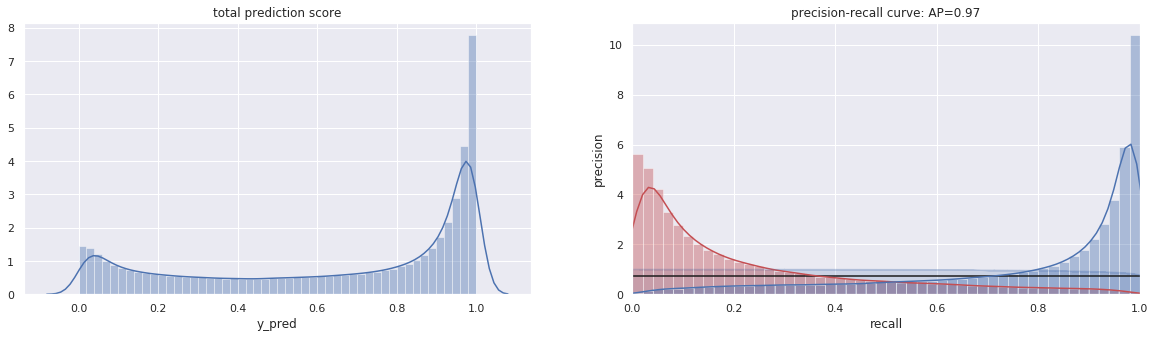

In [186]:
label = 'label_flagship_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

In [185]:
label = 'label_eqp_mdl_ntwk'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.880254  0.899795    0.83754  0.867552  0.953051
         pred: 1  pred: 0
true: 1   145747    16231
true: 0    28271   181388


In [182]:
label = 'label_note_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.868853  0.822202   0.595785  0.690917  0.924883
         pred: 1  pred: 0
true: 1    54475    11780
true: 0    36959   268423


In [183]:
label = 'label_tablet_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.963281  0.913043    0.01965  0.038472  0.934378
         pred: 1  pred: 0
true: 1      273       26
true: 0    13620   357718


In [184]:
label = 'label_disp_size_larg_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.804653  0.787402   0.871571  0.827352  0.888728
         pred: 1  pred: 0
true: 1   173949    46966
true: 0    25632   125090


In [333]:
label_cols

['label_mfact',
 'label_eqp_mdl_size',
 'label_disp_size_larg_yn',
 'label_note_yn',
 'label_flagship_yn',
 'label_first_eqp_out_prc',
 'label_out_prc']

In [188]:
clf_dict

{'label_mfact': <lightgbm.basic.Booster at 0x7fcd4fcd23c8>,
 'label_note_yn': <lightgbm.basic.Booster at 0x7fcd57b5a4e0>,
 'label_tablet_yn': <lightgbm.basic.Booster at 0x7fcd4b4a13c8>,
 'label_disp_size_larg_yn': <lightgbm.basic.Booster at 0x7fcd57c2ba90>,
 'label_flagship_yn': <lightgbm.basic.Booster at 0x7fcd57b5e8d0>,
 'label_eqp_mdl_ntwk': <lightgbm.basic.Booster at 0x7fcd57b5e860>,
 'label_first_eqp_out_prc': <lightgbm.basic.Booster at 0x7fcd57cd50f0>,
 'label_out_prc': <lightgbm.basic.Booster at 0x7fcd57d04860>}

In [17]:
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

In [18]:
def save_model(model, file_name):
    path = os.path.join(MODEL_PATH, file_name)
    print('save model to ', path)
    with open(path, 'wb') as f:
        pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(file_name):
    path = os.path.join(MODEL_PATH, file_name)
    print('load model from ', file_name)q
    with open(path, 'rb') as f:
        model = pickle.load(f)
    return model

In [197]:
for name, clf in clf_dict.items():
    nm = name.split('_')[1]
    file_name = 'baseline_'+nm+'.pkl'
    save_model(clf, file_name)

save model to  /home/dmig/work/dominic_workspace/model/baseline_mfact.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_note.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_tablet.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_disp.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_flagship.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_eqp.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_first.pkl
save model to  /home/dmig/work/dominic_workspace/model/baseline_out.pkl


In [20]:
clf_dict = {}
for col in label_cols:
    nm = col.split('_')[1]
    file_name = 'baseline_'+nm+'.pkl'
    clf = load_model(file_name)
    clf_dict[col] = clf

load model from  baseline_mfact.pkl
load model from  baseline_note.pkl
load model from  baseline_tablet.pkl
load model from  baseline_disp.pkl
load model from  baseline_flagship.pkl
load model from  baseline_eqp.pkl
load model from  baseline_first.pkl
load model from  baseline_out.pkl


In [198]:
df_val.shape

(371637, 411)

In [199]:
df_val.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
178475    7277007035       1  28.0     47502.8889             0.0   
207804    7271067659       2  29.0     65219.0000             0.0   
221253    7274169677       2  45.0     41442.1111             0.0   
417651    7020492129       2  58.0     11669.6250             0.0   
1423186   7227041255       2  42.0     71819.0000             0.0   

         last_eqp_buy_duration  tw_visit_days_fee_t_small  \
178475                     0.0                        0.0   
207804                    50.0                        0.0   
221253                     0.0                        0.0   
417651                   148.0                        0.0   
1423186                   22.0                        0.0   

         location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
178475                          51.0                                 0.0   
207804                          47.0                                 0.0   
221253                           2.0                                 0.0   
417651                          15.0                                 0.0   
1423186                         11.0                                 0.0   

         mbr_discount_amt_family_restaurant  ...  days_from_eqp_acqr_dt  \
178475                                  0.0  ...                    830   
207804                                  0.0  ...                    337   
221253                                  0.0  ...                    938   
417651                                  0.0  ...                    690   
1423186                                 0.0  ...                    774   

         days_from_mktg_dt  label_mfact  label_note_yn  label_tablet_yn  \
178475                1048            3              0                0   
207804                 387            3              0                0   
221253                1329            3              0                0   
417651                 838            3              0                0   
1423186                807            3              1                0   

         label_disp_size_larg_yn  label_flagship_yn  label_eqp_mdl_ntwk  \
178475                         0                  1                   0   
207804                         0                  1                   0   
221253                         1                  0                   0   
417651                         0                  1                   0   
1423186                        1                  1                   1   

         label_first_eqp_out_prc  label_out_prc  
178475                    4125.0         4125.0  
207804                  899800.0       899800.0  
221253                  599500.0       599500.0  
417651                  935000.0       599500.0  
1423186                1496000.0      1496000.0  

[5 rows x 411 columns]

In [200]:
from shap_tools import ShapModule

In [201]:
sm = ShapModule(df_val, 
                model=clf_dict['label_mfact'], 
                features=clf_dict['label_mfact'].feature_name(),
                idx_col='svc_mgmt_num',
                target_col='label_mfact')

In [202]:
sm.calculate_shap_value()

ValueError: Must pass 2-d input

In [203]:
df_trn.to_pickle(os.path.join(DATA_PATH, 'eqp_trn.pkl'))
df_val.to_pickle(os.path.join(DATA_PATH, 'eqp_val.pkl'))

In [21]:
# df_trn = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_trn.pkl'))
df_val = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_val.pkl'))

In [22]:
df_val.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
178475    7277007035       1  28.0     47502.8889             0.0   
207804    7271067659       2  29.0     65219.0000             0.0   
221253    7274169677       2  45.0     41442.1111             0.0   
417651    7020492129       2  58.0     11669.6250             0.0   
1423186   7227041255       2  42.0     71819.0000             0.0   

         last_eqp_buy_duration  tw_visit_days_fee_t_small  \
178475                     0.0                        0.0   
207804                    50.0                        0.0   
221253                     0.0                        0.0   
417651                   148.0                        0.0   
1423186                   22.0                        0.0   

         location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
178475                          51.0                                 0.0   
207804                          47.0                                 0.0   
221253                           2.0                                 0.0   
417651                          15.0                                 0.0   
1423186                         11.0                                 0.0   

         mbr_discount_amt_family_restaurant  ...  days_from_eqp_acqr_dt  \
178475                                  0.0  ...                    830   
207804                                  0.0  ...                    337   
221253                                  0.0  ...                    938   
417651                                  0.0  ...                    690   
1423186                                 0.0  ...                    774   

         days_from_mktg_dt  label_mfact  label_note_yn  label_tablet_yn  \
178475                1048            3              0                0   
207804                 387            3              0                0   
221253                1329            3              0                0   
417651                 838            3              0                0   
1423186                807            3              1                0   

         label_disp_size_larg_yn  label_flagship_yn  label_eqp_mdl_ntwk  \
178475                         0                  1                   0   
207804                         0                  1                   0   
221253                         1                  0                   0   
417651                         0                  1                   0   
1423186                        1                  1                   1   

         label_first_eqp_out_prc  label_out_prc  
178475                    4125.0         4125.0  
207804                  899800.0       899800.0  
221253                  599500.0       599500.0  
417651                  935000.0       599500.0  
1423186                1496000.0      1496000.0  

[5 rows x 411 columns]

In [23]:
df_meta.head()

eqp_mdl_cd rep_eqp_mdl_cd    eqp_nm_rmk  eqp_pet_nm    mfact_nm   mktg_dt  \
0       A003           A003  OMD SONY XZP  XZ Premium  블랙리스트_Sony  20170515   
1       A006           SS3U       J5 2017     J5 2017     삼성전자(주)  20170704   
2       A009           SS3U       J5 2017     J5 2017     삼성전자(주)  20170704   
3       A00D           A032           G6+     G6 Plus     LG전자(주)  20170529   
4       A00E           SS3E     갤럭시S8_64G       갤럭시S8     삼성전자(주)  20180316   

  smart_phon_yn tablet_yn note_yn disp_size_larg_yn         eqp_siz_ctt  \
0             Y         N       N                 N                 000   
1             Y         N       N                 N      146.3*71.3*7.9   
2             Y         N       N                 N      146.3*71.3*7.9   
3             Y         N       N                 Y  148.9 x 71.9 x 7.9   
4             Y         N       N                 N      148.9*68.1*8.0   

  flagship_yn eqp_mdl_size eqp_mdl_ntwk  first_eqp_out_prc  
0           Y           64           4G           799700.0  
1           N         32GB           4G           344300.0  
2           N         None           4G           344300.0  
3           Y        128GB           4G           957000.0  
4           Y         64GB           4G           935000.0

In [35]:
df_merge.shape

(1486545, 411)

In [24]:
df_meta[df_meta['tablet_yn']=='Y']

eqp_mdl_cd rep_eqp_mdl_cd           eqp_nm_rmk          eqp_pet_nm  \
5         A00S           A00S               갤럭시탭S3          갤럭시 TAB S3   
10        A016           A015   IPAD PRO 12.9_64GW       IPAD PRO 12.9   
11        A01C           A01C   IPAD PRO 12.9_512G       IPAD PRO 12.9   
12        A01D           A01C  IPAD PRO 12.9_512GW       IPAD PRO 12.9   
13        A01F           A01F    IPAD PRO 10.5_64G       IPAD PRO 10.5   
..         ...            ...                  ...                 ...   
752       SSFI           SSFI       갤럭시 Tab Active      갤럭시 TAB ACTIVE   
756       SSI5           SSVX   갤럭시노트10.1 2014 에디션  갤럭시노트10.1 2014 에디션   
842       SSUG           SSUA                 갤럭시W                갤럭시W   
843       SSUJ           SSUA                 갤럭시W                갤럭시W   
844       SSUK           SSUA                 갤럭시W                갤럭시W   

    mfact_nm   mktg_dt smart_phon_yn tablet_yn note_yn disp_size_larg_yn  \
5    삼성전자(주)  20170524             N         Y       N                 N   
10     Apple  20170713             N         Y       Y                 N   
11     Apple  20170713             N         Y       Y                 N   
12     Apple  20170713             N         Y       Y                 N   
13     Apple  20170713             N         Y       Y                 N   
..       ...       ...           ...       ...     ...               ...   
752  삼성전자(주)  20150529             N         Y       N                 N   
756  삼성전자(주)  20131101             N         Y       N                 N   
842  삼성전자(주)  20140603             N         Y       N                 Y   
843  삼성전자(주)  20140603             N         Y       N                 Y   
844  삼성전자(주)  20140603             N         Y       N                 Y   

                eqp_siz_ctt flagship_yn eqp_mdl_size eqp_mdl_ntwk  \
5    237.3(H),169(W),6.0(D)           N         32GB           4G   
10          305.7*220.6*6.9           N         64GB           4G   
11          305.7*220.6*6.9           N        512GB           4G   
12          305.7*220.6*6.9           N        512GB           4G   
13          250.6*174.1*6.1           N         64GB           4G   
..                      ...         ...          ...          ...   
752                     100           N         16GB           4G   
756                     100           N         32GB           4G   
842                     TBD           N         16GB           4G   
843                     TBD           N         16GB           4G   
844                     TBD           N         16GB           4G   

     first_eqp_out_prc  
5             859000.0  
10           1120900.0  
11           1452000.0  
12           1452000.0  
13            935000.0  
..                 ...  
752                NaN  
756           946000.0  
842           499400.0  
843           499400.0  
844           499400.0  

[239 rows x 15 columns]

In [36]:
df_val.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
178475    7277007035       1  28.0     47502.8889             0.0   
207804    7271067659       2  29.0     65219.0000             0.0   
221253    7274169677       2  45.0     41442.1111             0.0   
417651    7020492129       2  58.0     11669.6250             0.0   
1423186   7227041255       2  42.0     71819.0000             0.0   

         last_eqp_buy_duration  tw_visit_days_fee_t_small  \
178475                     0.0                        0.0   
207804                    50.0                        0.0   
221253                     0.0                        0.0   
417651                   148.0                        0.0   
1423186                   22.0                        0.0   

         location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
178475                          51.0                                 0.0   
207804                          47.0                                 0.0   
221253                           2.0                                 0.0   
417651                          15.0                                 0.0   
1423186                         11.0                                 0.0   

         mbr_discount_amt_family_restaurant  ...  days_from_eqp_acqr_dt  \
178475                                  0.0  ...                    830   
207804                                  0.0  ...                    337   
221253                                  0.0  ...                    938   
417651                                  0.0  ...                    690   
1423186                                 0.0  ...                    774   

         days_from_mktg_dt  label_mfact  label_note_yn  label_tablet_yn  \
178475                1048            3              0                0   
207804                 387            3              0                0   
221253                1329            3              0                0   
417651                 838            3              0                0   
1423186                807            3              1                0   

         label_disp_size_larg_yn  label_flagship_yn  label_eqp_mdl_ntwk  \
178475                         0                  1                   0   
207804                         0                  1                   0   
221253                         1                  0                   0   
417651                         0                  1                   0   
1423186                        1                  1                   1   

         label_first_eqp_out_prc  label_out_prc  
178475                    4125.0         4125.0  
207804                  899800.0       899800.0  
221253                  599500.0       599500.0  
417651                  935000.0       599500.0  
1423186                1496000.0      1496000.0  

[5 rows x 411 columns]

eqp_mdl_cd rep_eqp_mdl_cd    eqp_nm_rmk  eqp_pet_nm    mfact_nm   mktg_dt  \
0         A003           A003  OMD SONY XZP  XZ Premium  블랙리스트_Sony  20170515   
1         A006           SS3U       J5 2017     J5 2017     삼성전자(주)  20170704   
2         A009           SS3U       J5 2017     J5 2017     삼성전자(주)  20170704   
3         A00D           A032           G6+     G6 Plus     LG전자(주)  20170529   
4         A00E           SS3E     갤럭시S8_64G       갤럭시S8     삼성전자(주)  20180316   
..         ...            ...           ...         ...         ...       ...   
875       WHAA           WHAA      NEXUS 6P    NEXUS 6P         화웨이  20151204   
876       XXC3           XXC3           리액션     SK-S100      SK텔레시스  20101022   
877       XXC6           XXC6        WYNN 2     SK-S170      SK텔레시스  20111115   
878       XXC7           XXC7       WYNN(윈)     SK-S150      SK텔레시스  20110517   
879       XXX2           XXX2     SDT-CS3B2   SDT-CS3B2      SK텔레시스  20170222   

    smart_phon_yn tablet_yn note_yn disp_size_larg_yn         eqp_siz_ctt  \
0               Y         N       N                 N                 000   
1               Y         N       N                 N      146.3*71.3*7.9   
2               Y         N       N                 N      146.3*71.3*7.9   
3               Y         N       N                 Y  148.9 x 71.9 x 7.9   
4               Y         N       N                 N      148.9*68.1*8.0   
..            ...       ...     ...               ...                 ...   
875             Y         N       N                 Y      159.3*77.8*7.3   
876             Y         N       N                 N      117.8*58*11.95   
877             Y         N       N                 N       128x63.6x11.5   
878             Y         N       N                 N     126.5x64.3x11.5   
879             Y         N       N                 N  140 * 85 * 28 (mm)   

    flagship_yn eqp_mdl_size eqp_mdl_ntwk  first_eqp_out_prc  
0             Y           64           4G           799700.0  
1             N         32GB           4G           344300.0  
2             N         None           4G           344300.0  
3             Y        128GB           4G           957000.0  
4             Y         64GB           4G           935000.0  
..          ...          ...          ...                ...  
875           N         32GB           4G           599500.0  
876           N         None         None           922900.0  
877           N         None         None           100000.0  
878           N         None         None           823900.0  
879           N         None         None                NaN  

[1849 rows x 15 columns]